# Visualize simulated dataset

In [1]:
using DataFrames
using CSV
using CairoMakie
using LaTeXStrings
using Statistics

In [2]:
dirname = "sim-dataset"
data = CSV.read("$dirname/$dirname-numpass-data.csv", DataFrame);
println("$(nrow(data)) samples")
describe(data)
numtrial = only(unique(data[!, :numtrial]))
println("$numtrial games for each set of parameter values.")

15000 samples
500 games for each set of parameter values.


In [3]:
# check if there is any missing sample
println("Data for the following seeds are missing:")
println([s for s in 1:maximum(data[:, :seed]) if !(s in data[!, :seed])])

Data for the following seeds are missing:
Int64[]


## Histograms for original data

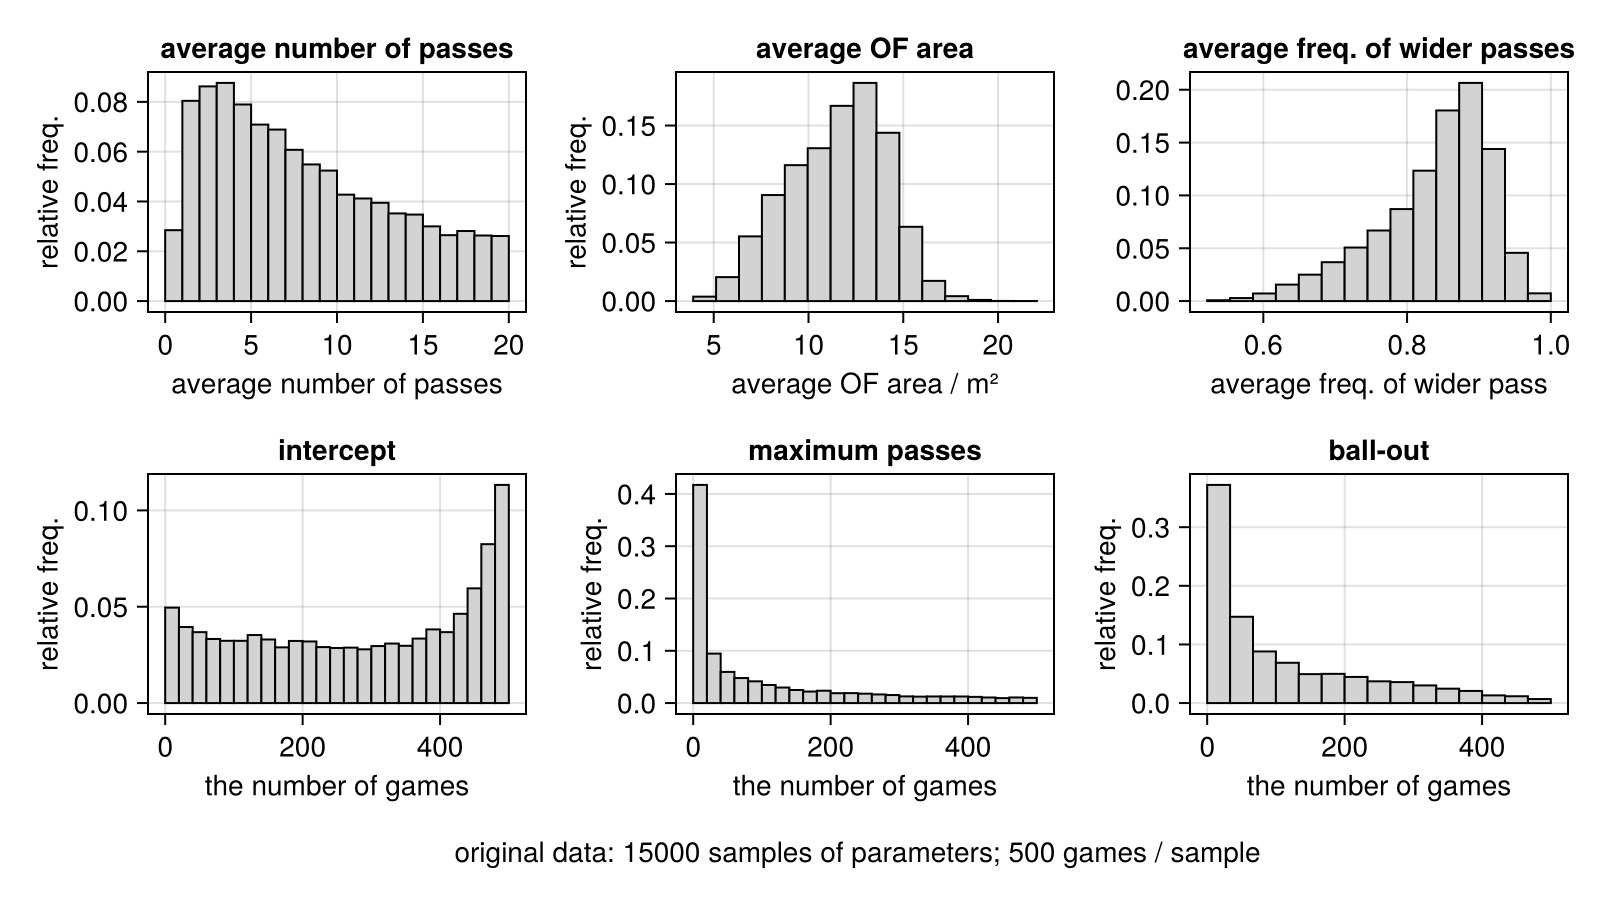

In [4]:
f = Figure(size=(800, 450))
histstyle = Dict(:color => :lightgray, :strokewidth => 1, :normalization => :probability)
ylab = "relative freq."

ax_np = Axis(f[1, 1], title="average number of passes", 
    xlabel="average number of passes", ylabel=ylab,
)
h_np = hist!(ax_np, data[!, :passcount_mean], bins=0:20; histstyle...)

ax_aa = Axis(f[1, 2], title="average OF area", xlabel="average OF area / m²", ylabel=ylab,)
h_aa = hist!(ax_aa, data[!, :avearea_mean]; histstyle...)

ax_pf = Axis(f[1, 3], title="average freq. of wider passes", 
    xlabel="average freq. of wider pass"
)
h_pf = hist!(ax_pf, data[!, :passwide_freq]; histstyle...)

mybins = range(0, 500, 26)

ax_int = Axis(f[2, 1], title="intercept", xlabel="the number of games", ylabel=ylab,)
h_int = hist!(ax_int, data[!, :intercept], bins=mybins; histstyle...)

ax_mp = Axis(f[2, 2], title="maximum passes", xlabel="the number of games", ylabel=ylab,)
h_mp = hist!(
    ax_mp, data[!, :max_pass], bins=mybins;
    histstyle...
)

ax_bo = Axis(f[2, 3], title="ball-out", xlabel="the number of games", ylabel=ylab,)
h_bo = hist!(
    ax_bo, data[!, :ball_out]; 
    histstyle...
)

Label(
    f[3, 1:3], 
    "original data: " *
    "$(size(data)[1]) samples of parameters; $(numtrial) games / sample",
)

save("$dirname-hist-org_data.pdf", f)

f

In [5]:
# load empirical data
empdata = (
    top=CSV.read("emp-dataset/numpass-area-top.csv", DataFrame),
    sec=CSV.read("emp-dataset/numpass-area-2nd.csv", DataFrame)
);
emp_np = (
    top=mean(empdata.top[:, "passcount"]),
    sec=mean(empdata.sec[:, "passcount"]),
);
emp_ma = (
    top=mean(empdata.top[:, "meanarea"]),
    sec=mean(empdata.sec[:, "meanarea"]),
);

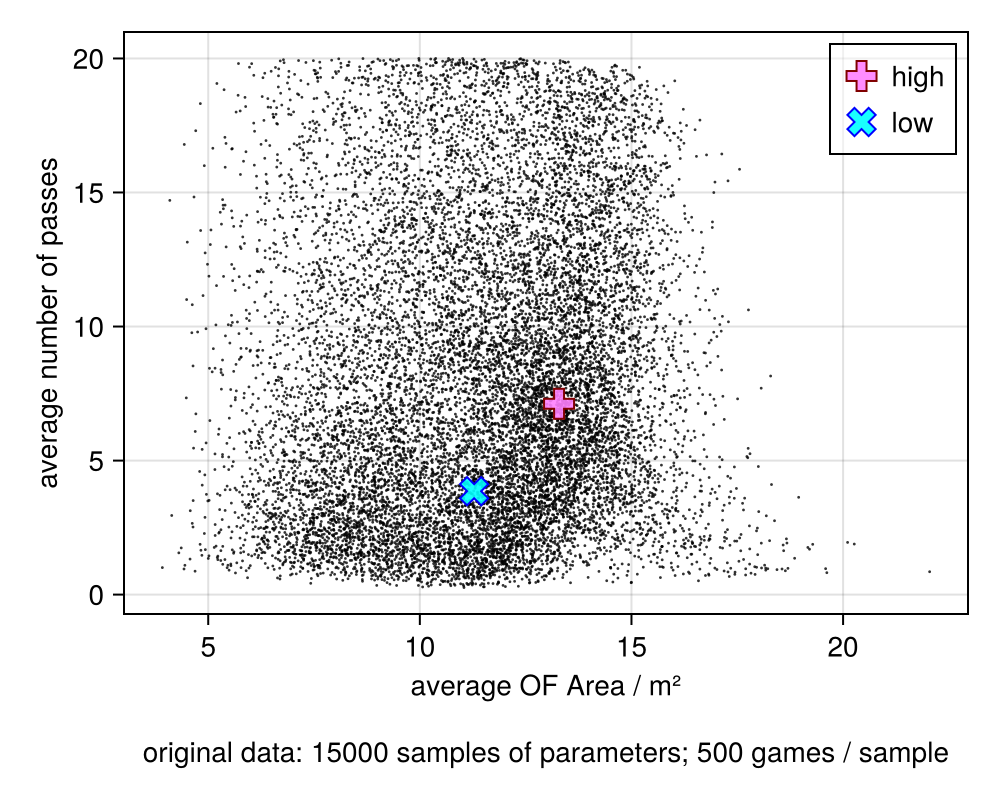

In [6]:
f = Figure(size=(500, 400))
ax = Axis(
    f[1, 1], xlabel="average OF Area / m²", ylabel="average number of passes"
)
sc_np_ma = scatter!(
    ax, data[!, :avearea_mean], data[!, :passcount_mean],
    color=(:black, 0.8), markersize=2,
)
markerstyle = Dict(
    :markersize => 20, :strokewidth => 1,
)
# grayscale = 0.299 R + 0.587 G + 0.114 B
m_top = scatter!(ax, emp_ma.top, emp_np.top, 
    marker=:cross, label="high", 
    color=RGBAf(1, 0.5, 1, 0.9), strokecolor=RGBf(0.5, 0, 0); 
    markerstyle...
)
m_sec = scatter!(ax, emp_ma.sec, emp_np.sec, 
    marker=:xcross, label="low", color=(:cyan, 0.9), strokecolor=:blue; 
    markerstyle...
)
axislegend(ax, position=:rt, backgroundcolor=(:white, 0.5))
Label(
    f[2, 1], 
    "original data: " *
    "$(size(data)[1]) samples of parameters; $(numtrial) games / sample",
)
# adjust axis size
colsize!(f.layout, 1, Relative(1))

#save("$dirname-org-area-numpass-scatter.pdf", f)
f

## Preprocessing

In [7]:
# thresholds
th_np = 1 # < passcount_mean
th_ma = 18  # >= mean of area
th_bout = 400  # > frequency of ball_out

400

In [8]:
# samples with too large areas
pair_np = :passcount_mean => np -> np .< th_np  # pair for subset()
println("$(nrow(subset(data, pair_np))) samples with too few passes")
describe(subset(data, pair_np))

427 samples with too few passes


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,seed,7271.85,37,7240.0,14978,0,Int64
2,passcount_mean,0.743724,0.264,0.774,0.998,0,Float64
3,passcount_var,1.18959,0.00597595,1.17696,3.11219,0,Float64
4,passwide_freq,0.909349,0.755601,0.914894,1.0,0,Float64
5,avearea_mean,11.1574,4.42789,11.0428,22.0448,0,Float64
6,vararea_mean,2.92569,0.0270901,0.895713,46.0339,0,Float64
7,intercept,446.04,6,480.0,500,0,Int64
8,max_pass,0.00234192,0,0.0,1,0,Int64
9,ball_out,53.9578,0,20.0,494,0,Int64


In [9]:
# samples with too large areas
pair_ma = :avearea_mean => aa -> aa .> th_ma  # pair for subset()
println("$(nrow(subset(data, pair_ma))) samples with too large areas")
describe(subset(data, pair_ma))

31 samples with too large areas


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,seed,7200.68,767,7686.0,14645,0,Int64
2,passcount_mean,2.11884,0.818,1.76,8.154,0,Float64
3,passcount_var,3.81587,0.00597595,0.757014,32.363,0,Float64
4,passwide_freq,0.966581,0.86865,0.975207,1.0,0,Float64
5,avearea_mean,18.783,18.0068,18.5838,22.0448,0,Float64
6,vararea_mean,15.923,4.52628,15.6925,46.0339,0,Float64
7,intercept,39.0968,0,32.0,111,0,Int64
8,max_pass,2.29032,0,0.0,45,0,Int64
9,ball_out,458.613,389,465.0,500,0,Int64


In [10]:
# samples with too many player_out
pair_bout = :ball_out => bout -> bout .> th_bout
println("$(nrow(subset(data, pair_bout))) samples with too many ball-out events")
describe(subset(data, pair_bout))

475 samples with too many ball-out events


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,seed,7227.35,12,6938.0,14975,0,Int64
2,passcount_mean,4.93616,0.756,4.864,10.896,0,Float64
3,passcount_var,18.3114,0.00597595,18.6079,49.5297,0,Float64
4,passwide_freq,0.901675,0.645478,0.911697,1.0,0,Float64
5,avearea_mean,15.6702,11.7037,15.5314,20.2643,0,Float64
6,vararea_mean,4.46582,0.35933,3.11923,22.8593,0,Float64
7,intercept,40.7011,0,40.0,99,0,Int64
8,max_pass,16.4884,0,7.0,90,0,Int64
9,ball_out,442.811,401,440.0,500,0,Int64


In [11]:
# exclude outliers
pro_data = subset(
    data, 
    :passcount_mean => np -> np .>= th_np,
    :ball_out => bo -> bo .< th_bout,
)
datasize = nrow(pro_data)
println("$(datasize) samples")
describe(pro_data)

14105 samples


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,seed,7517.92,1,7523.0,15000,0,Int64
2,passcount_mean,8.37948,1.0,7.356,20.0,0,Float64
3,passcount_var,29.3126,0.0,30.321,71.4152,0,Float64
4,passwide_freq,0.834219,0.52189,0.852984,1.0,0,Float64
5,avearea_mean,11.3848,3.91655,11.7145,17.7917,0,Float64
6,vararea_mean,1.34643,0.0572001,0.994787,17.094,0,Float64
7,intercept,289.908,0,310.0,500,0,Int64
8,max_pass,107.244,0,44.0,500,0,Int64
9,ball_out,102.848,0,59.0,399,0,Int64


### Histograms

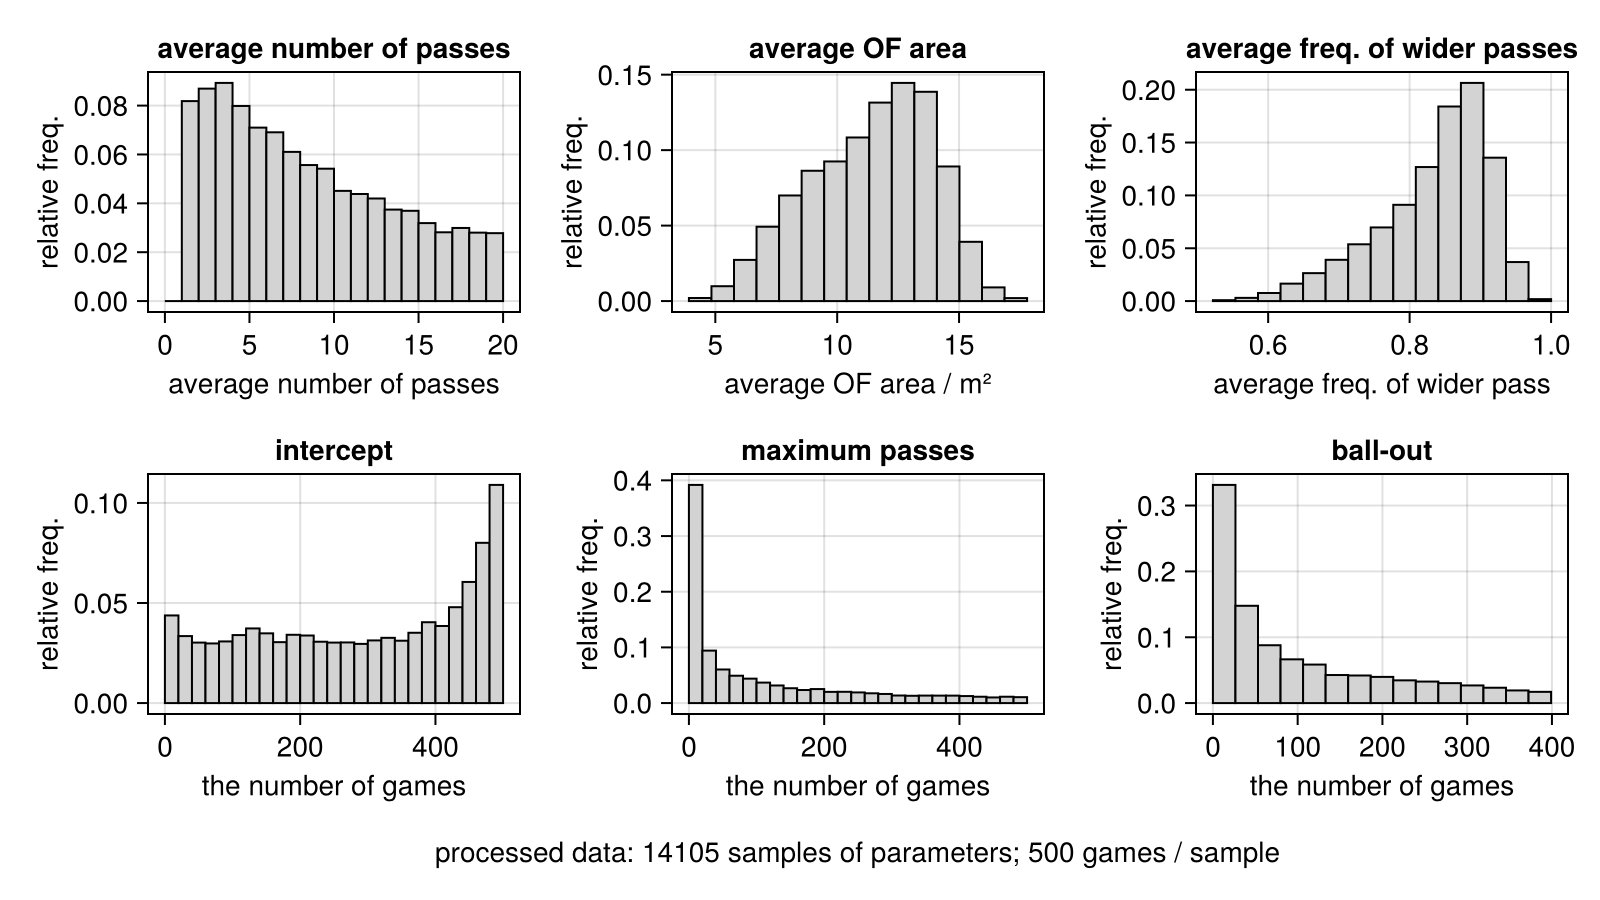

In [12]:
f = Figure(size=(800, 450))
histstyle = Dict(:color => :lightgray, :strokewidth => 1, :normalization => :probability)
ylab = "relative freq."

ax_np = Axis(f[1, 1], title="average number of passes", 
    xlabel="average number of passes", ylabel=ylab,
)
h_np = hist!(ax_np, pro_data[!, :passcount_mean], bins=0:20; histstyle...)

ax_aa = Axis(f[1, 2], title="average OF area", xlabel="average OF area / m²", ylabel=ylab)
h_aa = hist!(ax_aa, pro_data[!, :avearea_mean]; histstyle...)

ax_pf = Axis(f[1, 3], title="average freq. of wider passes", 
    xlabel="average freq. of wider pass", ylabel=ylab,
)
h_pf = hist!(ax_pf, pro_data[!, :passwide_freq]; histstyle...)

mybins = range(0, 500, 26)

ax_int = Axis(f[2, 1], title="intercept", xlabel="the number of games", ylabel=ylab,)
h_int = hist!(ax_int, pro_data[!, :intercept], bins=mybins; histstyle...)

ax_mp = Axis(f[2, 2], title="maximum passes", xlabel="the number of games", ylabel=ylab,)
h_mp = hist!(
    ax_mp, pro_data[!, :max_pass], bins=mybins;
    histstyle...
)

ax_bo = Axis(f[2, 3], title="ball-out", xlabel="the number of games", ylabel=ylab)
h_bo = hist!(ax_bo, pro_data[!, :ball_out]; histstyle...)

Label(
    f[3, 1:3], 
    "processed data: " *
    "$(size(pro_data, 1)) samples of parameters; $(numtrial) games / sample",
)

save("$dirname-hist-pro_data.pdf", f)

f

### Scatter plots

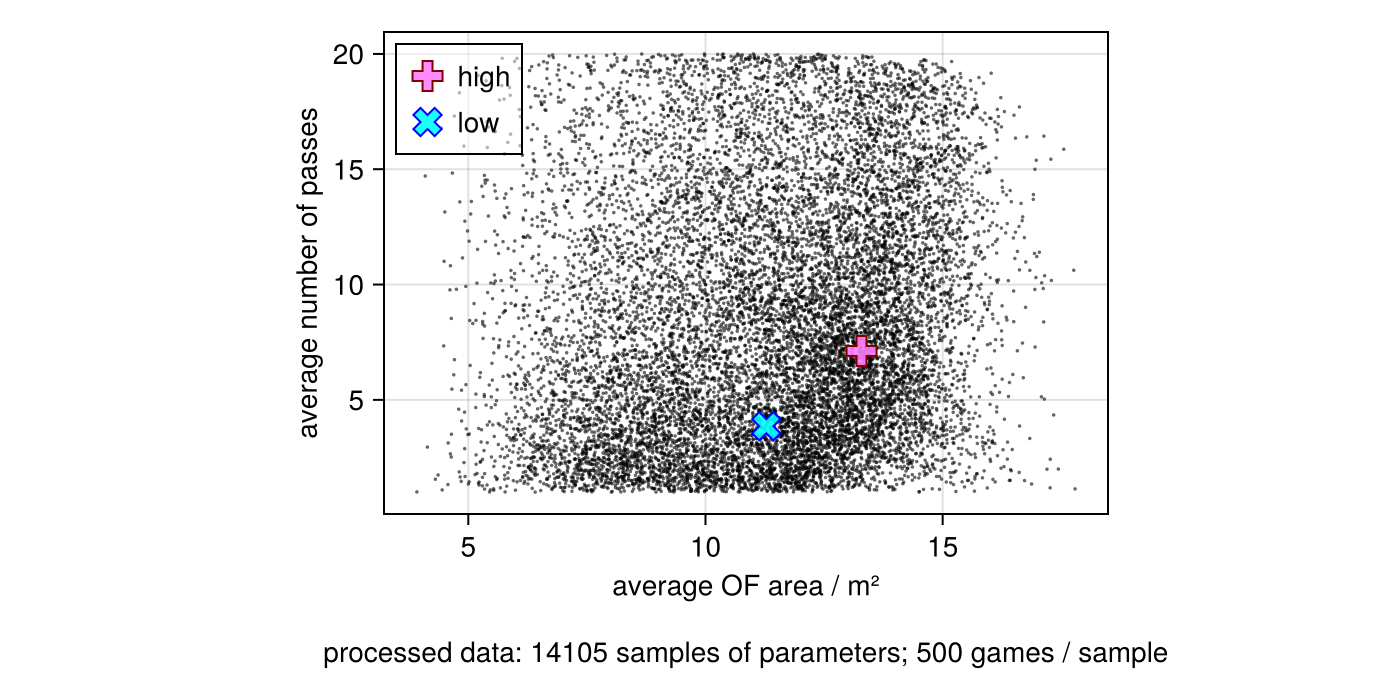

In [13]:
f = Figure(size=(700, 350))
ax = Axis(
    f[1, 1],
    xlabel="average OF area / m²", ylabel="average number of passes"
)
sc_np_ma = scatter!(
    ax, pro_data[!, :avearea_mean], pro_data[!, :passcount_mean],
    color=(:black, 0.6), markersize=2.5,
)
# grayscale = 0.299 R + 0.587 G + 0.114 B
m_top = scatter!(ax, emp_ma.top, emp_np.top, 
    marker=:cross, label="high", 
    color=RGBAf(1, 0.5, 1, 0.9), strokecolor=RGBf(0.5, 0, 0); 
    markerstyle...
)
m_sec = scatter!(ax, emp_ma.sec, emp_np.sec, 
    marker=:xcross, label="low", color=(:cyan, 0.9), strokecolor=:blue; 
    markerstyle...
)
axislegend(ax, position=:lt, backgroundcolor=(:white, 0.5))

Label(
    f[2, 1], 
    "processed data: " *
    "$(size(pro_data, 1)) samples of parameters; $(numtrial) games / sample",
)

# adjust axis size
colsize!(f.layout, 1, Aspect(1, 3 / 2))

save("$dirname-area-numpass-scatter.pdf", f)
f

### Parameter values that mimiced empirical observations

In [14]:
range_T = (0.65, 0.85)
range_pw = (0.4, 0.85)  # passwide_freq
range_Lf = (4, 6)
range_Le = (2, 4)

(2, 4)

In [15]:
range_top = (ma=0.5, np=0.5)
println("observation for top: $(round(emp_np.top, digits=2)) passes, $(round(emp_ma.top, digits=2)) m^2")
subset(
    pro_data, 
    :avearea_mean => aa -> emp_ma.top - range_top.ma .< aa .< emp_ma.top + range_top.ma,
    :passcount_mean => np -> emp_np.top - range_top.np .< np .< emp_np.top + range_top.np,
    :T => t -> range_T[1] .<= t .<= range_T[2],
    :passwide_freq => pw -> range_pw[1] .<= pw .<= range_pw[2],
    :Lf => Lf -> range_Lf[1] .<= Lf .<= range_Lf[2],
    :Le => Le -> range_Le[1] .<= Le .<= range_Le[2],
)

observation for top: 7.12 passes, 13.29 m^2


Row,seed,passcount_mean,passcount_var,passwide_freq,avearea_mean,vararea_mean,intercept,max_pass,ball_out,numtrial,Δt,m,T,σ,β,kr,γ,kf,Lf,ke,Le,q,τ,L_ict,L,L_buff,maxpass,L_out
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,13089,7.49,35.6612,0.842724,12.8584,1.10622,156,35,309,500,0.01,71.2689,0.747827,7.96642,8.37205,611.849,674.079,17.2089,5.08589,176.722,3.97586,0.271302,1.39551,0.648577,6.0,0.5,20,0.5


In [16]:
range_sec = (ma=0.15, np=0.15)
println("observation for 2nd: $(round(emp_np.sec, digits=2)) passes, $(round(emp_ma.sec, digits=2)) m^2")
subset(
    pro_data, 
    :avearea_mean => aa -> emp_ma.sec - range_sec.ma .< aa .< emp_ma.sec + range_sec.ma,
    :passcount_mean => np -> emp_np.sec - range_sec.np .< np .< emp_np.sec + range_sec.np,
    :T => t -> range_T[1] .<= t .<= range_T[2],
    :passwide_freq => pw -> range_pw[1] .<= pw .<= range_pw[2],
)

observation for 2nd: 3.86 passes, 11.28 m^2


Row,seed,passcount_mean,passcount_var,passwide_freq,avearea_mean,vararea_mean,intercept,max_pass,ball_out,numtrial,Δt,m,T,σ,β,kr,γ,kf,Lf,ke,Le,q,τ,L_ict,L,L_buff,maxpass,L_out
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,2655,3.762,14.5986,0.806486,11.2154,0.174639,477,4,19,500,0.01,66.0524,0.766763,5.29887,8.99913,244.681,444.966,100.889,4.41731,148.659,3.52914,0.618888,0.596025,0.651931,6.0,0.5,20,0.5
2,8805,3.806,19.796,0.829743,11.1925,0.288304,388,6,106,500,0.01,56.5942,0.655951,8.42011,5.73564,810.609,949.121,144.419,3.17605,178.664,4.69334,0.241957,0.511201,0.564797,6.0,0.5,20,0.5
